<a href="https://colab.research.google.com/github/hesnacaliskan/Cure_the_Princess_Regularization/blob/main/cure_the_princess_l2reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io

In [ ]:
import torch
import torch.nn as nn
#import torchvision
#import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.manual_seed(190401007)

In [ ]:
uploaded = files.upload()

Saving cure_the_princess_test.csv to cure_the_princess_test (1).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (1).csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation (1).csv


In [ ]:
train_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_train.csv']))
train_labels = train_data.iloc[:, -1]
train_data = train_data.iloc[:, :-1]

val_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_validation.csv']))
val_labels = val_data.iloc[:, -1]
val_data = val_data.iloc[:, :-1] 

test_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_test.csv']))
test_labels = test_data.iloc[:, -1]
test_data = test_data.iloc[:, :-1]

In [ ]:
train_data = torch.Tensor(train_data.values)
train_labels = torch.Tensor(train_labels.values).view(-1, 1)

test_data = torch.Tensor(test_data.values)
test_labels = torch.Tensor(test_labels.values).view(-1, 1)

val_data = torch.Tensor(val_data.values)
val_labels = torch.Tensor(val_labels.values).view(-1, 1)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, reg_param):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.reg_param = reg_param
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out
      
    def l2_regularization(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += torch.norm(param)
        return l2_loss * self.reg_param
      
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
learning_rate = 0.001
epochs = 100
batch_size = 32
reg_param = 0.001 # L2 regularization parameter

model = MLP(input_size, hidden_size1, hidden_size2, output_size, reg_param)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
val_losses = []
reg_losses = [] # L2 regularization losses

for epoch in range(epochs):
    # Train
    model.train()
    train_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        # Get batch of data
        batch_data = train_data[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        # Add L2 regularization loss
        reg_loss = model.l2_regularization()
        loss += reg_loss
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_data.size(0)
    train_loss = train_loss / len(train_data)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_data), batch_size):
            # Get batch of data
            batch_data = val_data[i:i+batch_size]
            batch_labels = val_labels[i:i+batch_size]  
                    # Forward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels.view(-1, 1))
            val_loss += loss.item() * batch_data.size(0)
        
            # L2 regularization
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
              l2_reg += torch.norm(param, p=2)**2
        loss += 0.001 * l2_reg
        
        val_loss = val_loss / len(val_data)
        val_losses.append(val_loss)

  # Print epoch and loss
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    


Epoch [10/100], Train Loss: 0.4971, Validation Loss: 0.4502
Epoch [20/100], Train Loss: 0.3919, Validation Loss: 0.3469
Epoch [30/100], Train Loss: 0.3282, Validation Loss: 0.2850
Epoch [40/100], Train Loss: 0.2898, Validation Loss: 0.2489
Epoch [50/100], Train Loss: 0.2653, Validation Loss: 0.2277
Epoch [60/100], Train Loss: 0.2479, Validation Loss: 0.2139
Epoch [70/100], Train Loss: 0.2340, Validation Loss: 0.2035
Epoch [80/100], Train Loss: 0.2222, Validation Loss: 0.1947
Epoch [90/100], Train Loss: 0.2121, Validation Loss: 0.1877
Epoch [100/100], Train Loss: 0.2031, Validation Loss: 0.1819


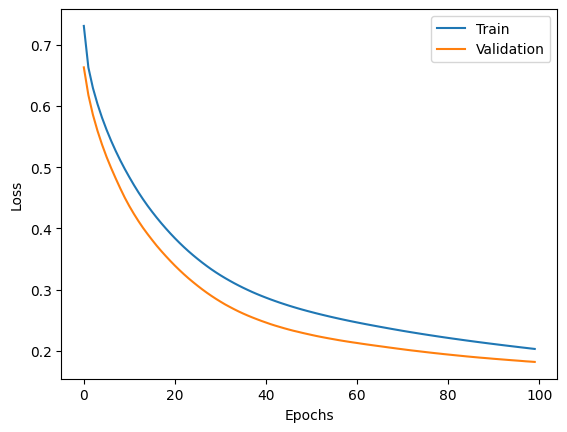

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Compute validation accuracy, precision, recall and F1 score
tp = 0  # True positives
fp = 0  # False positives
tn = 0  # True negatives
fn = 0  # False negatives
model.eval()
with torch.no_grad():
      for i in range(0, len(test_data), batch_size):
            # Get batch of data
        batch_data = test_data[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]

            # Forward pass
        outputs = model(batch_data)
        predicted_labels = (outputs >= 0.5).float()

            # Update confusion matrix
        tp += torch.sum(predicted_labels * batch_labels).item()
        fp += torch.sum(predicted_labels * (1 - batch_labels)).item()
        tn += torch.sum((1 - predicted_labels) * (1 - batch_labels)).item()
        fn += torch.sum((1 - predicted_labels) * batch_labels).item()

    # Compute accuracy, precision, recall and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f'Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')

Test Accuracy: 0.9197, Test Precision: 0.9158, Test Recall: 0.9253, Test F1: 0.9205
